# Load the previously filtered dataset

In [ ]:
!wget 'https://storage.googleapis.com/ml-lambi-public/Dataset/Lambi_dataset_small.zip'

--2023-12-01 06:20:24--  https://storage.googleapis.com/ml-lambi-public/Dataset/Lambi_dataset_small.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.191.207, 173.194.74.207, 173.194.192.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.191.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42471658 (41M) [application/x-zip-compressed]
Saving to: ‘Lambi_dataset_small.zip’

Lambi_dataset_small 100%[===================>]  40.50M  12.8MB/s    in 4.0s    

2023-12-01 06:20:29 (10.2 MB/s) - ‘Lambi_dataset_small.zip’ saved [42471658/42471658]



In [ ]:
# Extract file

import zipfile

# Unzip file
zip_ref = zipfile.ZipFile('Lambi_dataset_small.zip', 'r')
zip_ref.extractall()

zip_ref.close()

# Import Library


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
import os

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications.inception_v3 import preprocess_input
import plotly.express as px

In [ ]:
print(tf.__version__)

2.14.0


In [ ]:
!nvidia-smi

Fri Dec  1 06:21:11 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Make Dataframe

In [ ]:
df = pd.read_csv('fashionDataset.csv', on_bad_lines='skip')

df

,index,id,masterCategory,subCategory,articleType,usage,baseColour,image
0,37590,5798,Apparel,Topwear,Tshirts,Casual,White,5798.jpg
1,17763,44309,Apparel,Bottomwear,Shorts,Casual,Brown,44309.jpg
2,24098,12503,Apparel,Topwear,Tshirts,Casual,Black,12503.jpg
3,14615,48081,Apparel,Topwear,Tshirts,Casual,Red,48081.jpg
4,33737,22406,Apparel,Topwear,Shirts,Formal,Purple,22406.jpg
...,...,...,...,...,...,...,...,...
7998,28095,57084,Apparel,Bottomwear,Skirts,Casual,Blue,57084.jpg
7999,34702,8474,Apparel,Topwear,Shirts,Casual,Black,8474.jpg
8000,9191,23162,Apparel,Topwear,Tshirts,Casual,Navy Blue,23162.jpg
8001,11588,6116,Apparel,Topwear,Tshirts,Casual,Purple,6116.jpg


In [ ]:
# Filter to imporant features

df = df[['image', 'articleType', 'baseColour']]

df = df.rename(columns={'articleType': 'label'})

In [ ]:
# Filter baseColour

value_counts = df['baseColour'].value_counts()

indexes = value_counts.index

values = value_counts.values

for i in range(len(value_counts)):

    if values[i] <100:
        break

colours_used = indexes[:i]

df = df[df['baseColour'].isin(colours_used)]

# Data Visualization

In [ ]:
fig = px.bar(df['label'].value_counts())
fig.show()

In [ ]:
fig = px.bar(df['baseColour'].value_counts())
fig.show()

# Convert to numpy arrays

In [ ]:
df

,image,label,baseColour
0,5798.jpg,Tshirts,White
1,44309.jpg,Shorts,Brown
2,12503.jpg,Tshirts,Black
3,48081.jpg,Tshirts,Red
4,22406.jpg,Shirts,Purple
...,...,...,...
7998,57084.jpg,Skirts,Blue
7999,8474.jpg,Shirts,Black
8000,23162.jpg,Tshirts,Navy Blue
8001,6116.jpg,Tshirts,Purple


In [ ]:
data = []

# Reading all the images and processing the data in them

from tensorflow.keras.preprocessing.image import img_to_array
import cv2

IX = 80
IY = 60

invalid_ids = []

for name in df.image:

    try:
        image = cv2.imread('filter_images/'+str(name))
        image = cv2.resize(image, (IX,IY) )
        image = img_to_array(image)
        data.append(image)
    except:
        # Images for certain ids are missing, so they are not added to the dataset
        invalid_ids.append(name)

In [ ]:
print('invalid ids:')
print(len(invalid_ids))

invalid ids:
0


In [ ]:
labels = []

used_columns = ['label','baseColour']

# getting labels for the columns used

for index, row in df.iterrows():

    if row['image'] in invalid_ids:
        continue

    tags = []

    for col in used_columns:
        tags.append(row[col])

    labels.append(tags)

In [ ]:
import numpy as np

# converting data into numpy arrays

data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

print(labels)

[['Tshirts' 'White']
 ['Shorts' 'Brown']
 ['Tshirts' 'Black']
 ...
 ['Tshirts' 'Navy Blue']
 ['Tshirts' 'Purple']
 ['Shirts' 'Blue']]


# Make Binary Vectors

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

# creating a binary vector for the input labels

mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(labels)

print(mlb.classes_)
print(labels[2])

['Black' 'Blue' 'Brown' 'Capris' 'Dresses' 'Green' 'Grey' 'Jackets'
 'Jeans' 'Leggings' 'Navy Blue' 'Night suits' 'Nightdress' 'Orange' 'Pink'
 'Purple' 'Red' 'Shirts' 'Shorts' 'Skirts' 'Sweaters' 'Sweatshirts' 'Tops'
 'Track Pants' 'Trousers' 'Tshirts' 'White' 'Yellow']
[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]


# Model

In [ ]:
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D

inputShape = (IY, IX, 3)

# A very simple sequential model is used since the images are very low resolution and the categories are fiarly distinct

model = Sequential()

model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(128))
model.add(Activation('sigmoid'))


out = len(mlb.classes_)

model.add(Dense(out))
model.add(Activation('sigmoid')) # activation function for the final layer has to be sigmoid, since mutiple output labels can have value 1

model.compile(loss='binary_crossentropy', # loss function has to be binary_crossentropy, it is calculated seperately for each of the outputs
              optimizer='adam',
              metrics=['mse'])

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 60, 80, 32)        896       
                                                                 
 activation_12 (Activation)  (None, 60, 80, 32)        0         
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 30, 40, 32)        0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 30, 40, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 28, 38, 64)        18496     
                                                                 
 activation_13 (Activation)  (None, 28, 38, 64)        0         
                                                      

In [ ]:
from sklearn.model_selection import train_test_split

# splitting data into testing and training set

(trainX, testX, trainY, testY) = train_test_split(data,labels, test_size=0.1, random_state=42)

In [ ]:
batch = 32
E = 50

#training the model
history = model.fit(x=trainX,y=trainY,
          epochs=E ,verbose=1)

Epoch 1/50
205/205 [==============================] - 3s 9ms/step - loss: 0.2331 - mse: 0.0633
Epoch 2/50
205/205 [==============================] - 2s 9ms/step - loss: 0.2104 - mse: 0.0577
Epoch 3/50
205/205 [==============================] - 2s 9ms/step - loss: 0.2104 - mse: 0.0577
Epoch 4/50
205/205 [==============================] - 2s 8ms/step - loss: 0.2103 - mse: 0.0577
Epoch 5/50
205/205 [==============================] - 2s 8ms/step - loss: 0.2104 - mse: 0.0577
Epoch 6/50
205/205 [==============================] - 2s 8ms/step - loss: 0.2104 - mse: 0.0577
Epoch 7/50
205/205 [==============================] - 2s 8ms/step - loss: 0.2104 - mse: 0.0577
Epoch 8/50
205/205 [==============================] - 2s 8ms/step - loss: 0.2104 - mse: 0.0577
Epoch 9/50
205/205 [==============================] - 2s 9ms/step - loss: 0.2100 - mse: 0.0576
Epoch 10/50
205/205 [==============================] - 2s 9ms/step - loss: 0.1871 - mse: 0.0515
Epoch 11/50
205/205 [============================

# Prediction


In [ ]:
preds = model.predict(testX)


# since the predictions of the model are sigmoid, we will first binarize them to 0 or 1
pred_binarized = []

for pred in preds:
    vals = []
    for val in pred:
        if val > 0.5:
            vals.append(1)
        else:
            vals.append(0)
    pred_binarized.append(vals)

pred_binarized = np.array(pred_binarized)


# we convert the output vectors to the predicted labels
true_test_labels = mlb.inverse_transform(testY)
pred_test_labels = mlb.inverse_transform(pred_binarized)

correct = 0
wrong = 0

# Evaluating the predictions of the model

for i in range(len(testY)):

    true_labels = list(true_test_labels[i])

    pred_labels = list(pred_test_labels[i])

    label1 = true_labels[0]
    label2 = true_labels[1]

    if label1 in pred_labels:
        correct+=1
    else:
        wrong+=1

    if label2 in pred_labels:
        correct+=1
    else:
        wrong+=1



print('correct: ', correct)
print('missing/wrong: ', wrong)
print('Accuracy: ',correct/(correct+wrong))

23/23 [==============================] - 0s 3ms/step
correct:  1054
missing/wrong:  404
Accuracy:  0.7229080932784636


23/23 [==============================] - 0s 4ms/step


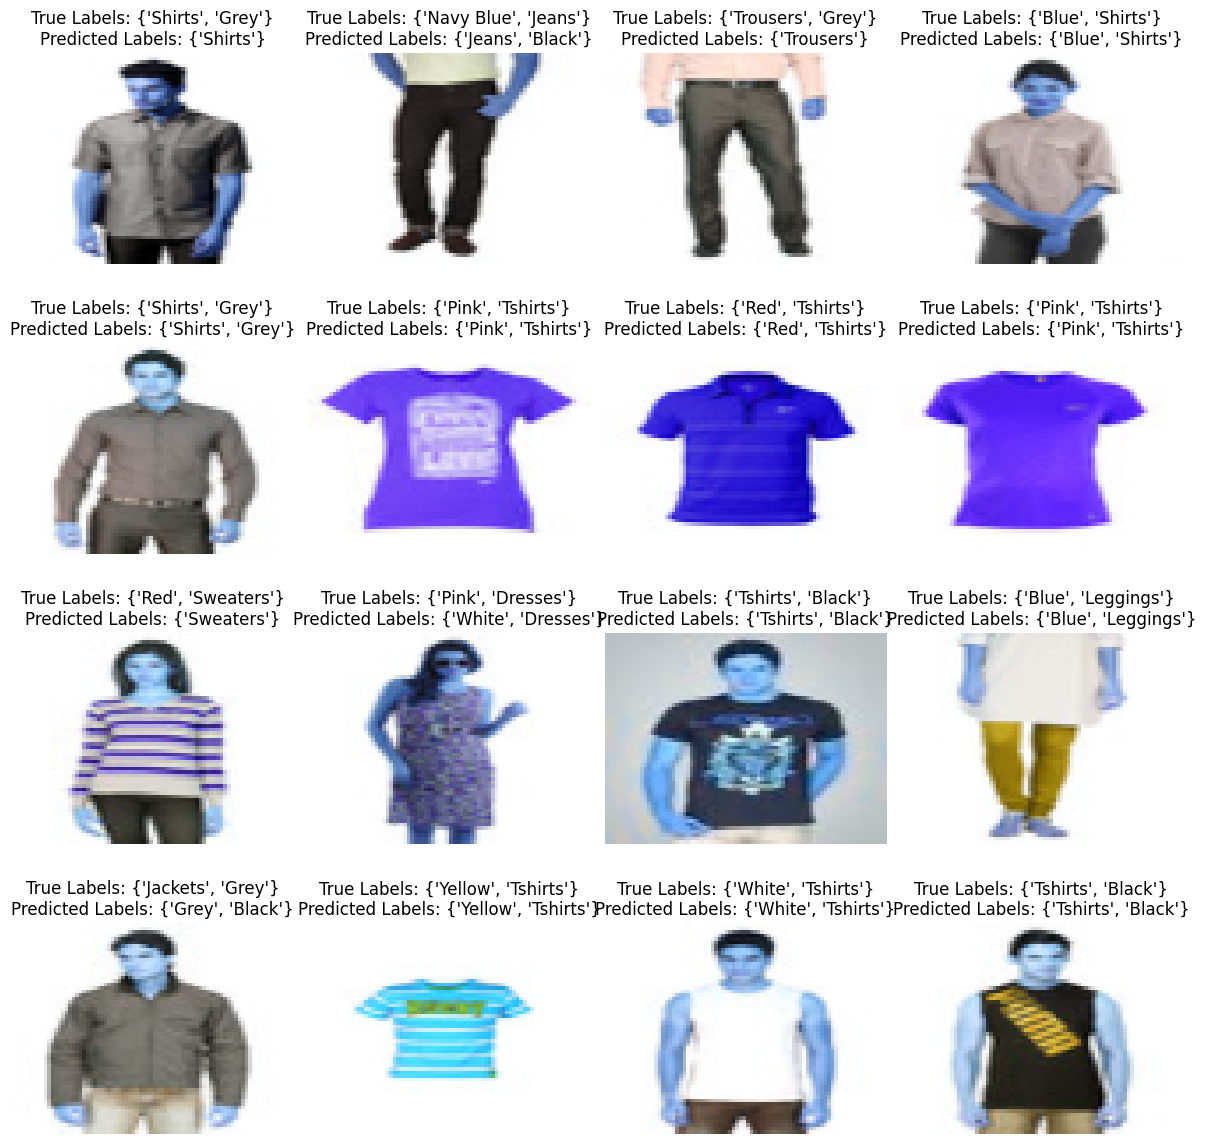

correct:  26
missing/wrong:  3
Accuracy:  0.896551724137931


In [ ]:
import matplotlib.pyplot as plt
import random

# Assuming 'testX' is your test data
# Assuming 'testY' is your true labels for the test data
# Assuming 'mlb' is your MultiLabelBinarizer

# Predictions
preds = model.predict(testX)

# Binarize predictions
pred_binarized = (preds > 0.5).astype(int)

# Convert predictions to labels
true_test_labels = mlb.inverse_transform(testY)
pred_test_labels = mlb.inverse_transform(pred_binarized)

correct = 0
wrong = 0

# Randomly select 4x4 samples for visualization
num_rows, num_cols = 4, 4
sample_indices = random.sample(range(len(testY)), min(num_rows * num_cols, len(testY)))

fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 12))

for i, idx in enumerate(sample_indices):
    row = i // num_cols
    col = i % num_cols

    true_labels = set(true_test_labels[idx])
    pred_labels = set(pred_test_labels[idx])

    # Count correct predictions
    correct += len(true_labels.intersection(pred_labels))

    # Count wrong predictions
    wrong += len(pred_labels.difference(true_labels))

    # Visualize the original image along with true and predicted labels
    img = testX[idx]  # Assuming your testX contains images
    axs[row, col].imshow(img)
    axs[row, col].set_title(f'True Labels: {true_labels}\nPredicted Labels: {pred_labels}')
    axs[row, col].axis('off')

plt.tight_layout()
plt.show()

accuracy = correct / (correct + wrong)

print('correct: ', correct)
print('missing/wrong: ', wrong)
print('Accuracy: ', accuracy)


# Model Evaluating

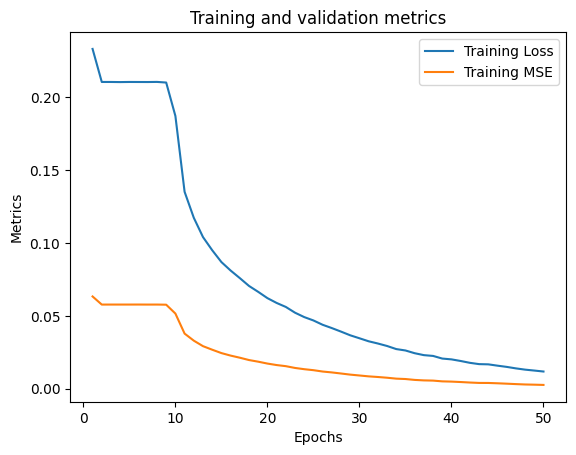

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history):
    '''Plot loss and mse as a function of the epoch for the training dataset.'''
    loss = history.history['loss']
    mse = history.history['mse']

    # Check if validation loss is available in the history
    val_loss_available = 'val_loss' in history.history
    val_mse_available = 'val_mse' in history.history

    # Get number of epochs
    epochs = range(1, len(loss) + 1)

    # Plot training loss and mse
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, mse, label='Training MSE')

    # If available, plot validation loss and mse
    if val_loss_available:
        plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
    if val_mse_available:
        plt.plot(epochs, history.history['val_mse'], label='Validation MSE')

    plt.title('Training and validation metrics')
    plt.xlabel('Epochs')
    plt.ylabel('Metrics')
    plt.legend()
    plt.show()

# Assuming 'history' contains the training history
plot_history(history)


# Save model to .h5 format


In [ ]:
from tensorflow.keras.models import load_model

# Assuming 'model' is your trained Keras model
model.save('fashion_fusion.h5')

# # Load
# loaded_model = load_model('fashion_fusion.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



In [ ]:
output_file_path = 'class.txt'

class_names = mlb.classes_

# Save class names to a text file
with open(output_file_path, 'w') as file:
    for class_name in class_names:
        file.write(f'{class_name}\n')

print(f'Class names saved to {output_file_path}')

Class names saved to class.txt
